### This model is trained on google colab with more number of data ( detail explained in report)

In [1]:
import cv2     # for capturing videos
import matplotlib.pyplot as plt    # for plotting the images
%matplotlib inline
import pandas as pd
from keras.preprocessing import image   # for preprocessing the images
from keras.utils import to_categorical
import numpy as np    
import os
import glob
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras import models
from keras import layers

Using TensorFlow backend.


In [9]:
# Renaming this code only one time

def rename_file (path , name):
    i=0                                         
    for filename in os.listdir(path):
        os.rename(os.path.join(path,filename), os.path.join(path, name + str(i)+'.avi'))
        i = i +1

#all_video_push = "D:\\tamu\\courses\\DeepLearning\\ProjectPart4\\pushing"
all_video_other = "D:\\tamu\\courses\\DeepLearning\\ProjectPart4\\other"

#rename_file(all_video_push, 'push_')
rename_file(all_video_other, 'other_')

In [2]:
# after renaming all videos (push and other) are manually pasted in one directory --> video_dir
video_dir = "D:\\tamu\\courses\\DeepLearning\\ProjectPart4\\all_video"
img_dir = "D:\\tamu\\courses\\DeepLearning\\ProjectPart4\\all_img"

## capture video

In [7]:
def get_frames(video_path, dest_path):
    file_name = video_path.split('.')[0].split('\\')[-1]
    vidcap = cv2.VideoCapture(video_path)

    sec = 0
    frameRate = 0.5 #//it will capture image in each 0.5 second
    count = 1
    hasFrames = True
    while hasFrames:
        vidcap.set(cv2.CAP_PROP_POS_MSEC,sec*1000)
        hasFrames,image = vidcap.read()
        if hasFrames:
            cv2.imwrite(dest_path+'\\'+file_name+'_'+ str(count)+".jpg", image)     # save frame as JPG file

        count = count + 1
        sec = sec + frameRate
        sec = round(sec, 2)

In [10]:
# getting captions from videos and put them in related derectories:

video_dir = "D:\\tamu\\courses\\DeepLearning\\ProjectPart4\\other"
img_dir = "D:\\tamu\\courses\\DeepLearning\\ProjectPart4\\other_img"

for i in range(len(os.listdir(video_dir))):
    video_path = video_dir + '\\' + os.listdir(video_dir)[i]
    dest_path = img_dir

    get_frames(video_path, dest_path)

### Getting labels
assign 0 to the images labeled as 'other' and assign 1 to the images labeld as 'push'

In [5]:
train_label =[]
for file in os.listdir(img_dir):
    label = file.split('_')[0]
    if label == 'other':
        train_label.append(0)
    else:
        train_label.append(1)
print (len(train_label))

670


### Image preprocessing
- I have two sets of videos. the first sets are videos taken by me vertically and the frames sizes are (720, 406, 3)
- the second sets are the video from internet dataset get frames with size of (240, 320, 3)
- So I have done some preprocessing to make them all the same size. (cropying the images with size (720, 406, 3) to (500, 406, 3), then resize them to (250,250,3)
- And resize frames with with size of (240, 320, 3) to (250,250,3) ==> in the end all frames have the same size of (250,250,3)

In [6]:
def get_Xtrain(file_name):
    X_train = []
    for i , filename in enumerate(glob.glob(file_name)):
        image = cv2.imread(filename)
        res_img = cv2.resize(image, dsize=(250,250), interpolation=cv2.INTER_CUBIC)
        X_train.append(res_img)
    
    return X_train 

X = get_Xtrain(img_dir + '\\*.jpg')

In [7]:
# checking the size of the resized images (X)
X[0].shape

(250, 250, 3)

## Get Numpy array of images

In [8]:
#transfering the train_list and label_list to array
X = np.asarray(X)
y = np.asarray(train_label)

In [9]:
print('X.shape: ', X.shape)
print('y.shape: ', y.shape)

X.shape:  (670, 250, 250, 3)
y.shape:  (670,)


In [10]:
## Normalizing X dataset:
X = X/X.max()                  

In [11]:
## split data to train and validation
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)  #by default shuffle is true

## Model Configuration
#### Using pre-trained model: Two ways to proceed:
1. Running the conv_base over our dataset, record the out put as numpy array and use this data as input to a standalone densely connected classifier. ==> fast and cheap , but does not allow data augmentation
2. exted the conv_base by adding Dense layers on top, run the whole model end to end ==> far more expensive, But allows data augmentation 
##### For this submission I use the second method

In [23]:
# Transfer Learning using pre-trained model

from keras.applications import VGG16

conv_base = VGG16(weights= 'imagenet', include_top=False, input_shape=(x_train.shape[1], x_train.shape[2], 3))

#if you don't give the input shape, it will retrieve it from data
#conv_base.summary()

In [24]:
conv_base.trainable = False

In [25]:

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
          
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               12845568  
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 257       
Total params: 27,691,841
Trainable params: 12,977,153
Non-trainable params: 14,714,688
_________________________________________________________________


In [15]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

In [16]:
#y_train = to_categorical(y_train, num_classes=2)       #No need to hot encode if you use binary
#y_valid = to_categorical(y_valid, num_classes=2)

# applying data augmentation on train set
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

datagen.fit(x_train)


In [17]:
validation_datagen = ImageDataGenerator()       # no augmentation for validation set
validation_datagen.fit(x_valid)

In [18]:
epochs = 3
history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=32),
                    steps_per_epoch=len(x_train) / 32, epochs=epochs,
                              validation_data=validation_datagen.flow(x_valid, y_valid, batch_size=32))

Epoch 1/3
15/14 [==============================] - 199s 13s/step - loss: 0.3881 - acc: 0.8635 - val_loss: 0.2197 - val_acc: 0.9801
Epoch 2/3
15/14 [==============================] - 188s 13s/step - loss: 0.1531 - acc: 0.9723 - val_loss: 0.1205 - val_acc: 0.9801
Epoch 3/3
15/14 [==============================] - 188s 13s/step - loss: 0.0818 - acc: 0.9893 - val_loss: 0.1755 - val_acc: 0.9950


### save the model

In [21]:
import json

model_dir = "D:\\tamu\\courses\\DeepLearning\\ProjectPart4\\results"

model_json = model.to_json()
with open(model_dir + "\\zz_CNN_model.json", "w") as json_file:
    json_file.write(model_json)
    # serialize weights to HDF5
model.save_weights(model_dir + "\\zz_CNN_model.h5")
print("Saved model to disk")

Saved model to disk


## Plotting the result

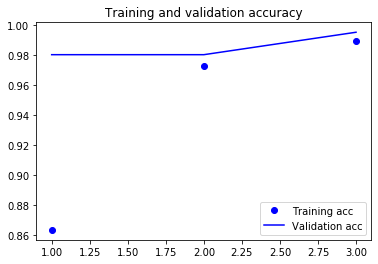

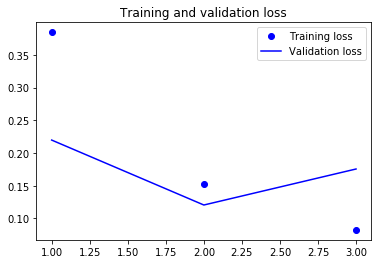

In [19]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot Training and Validation accuracy over epoch
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

# Plot Training and Validation loss over epoch
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()